In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Loading data

In [3]:
path_to_data = "../../../dataset_offline/ft2model/"

targets_df = pd.read_parquet(path_to_data + "target_pandas.parquet")
dataset = pd.read_parquet(path_to_data + "filtered_features.parquet")

dataset = dataset.drop_duplicates(subset='ID_CLIENTE_BIC', keep='first')

targets_df = targets_df.sort_values(by='ID_CLIENTE_BIC', ascending=True)
dataset = dataset.sort_values(by='ID_CLIENTE_BIC', ascending=True)

# Preprocessing

In [13]:
# Codifica le variabili categoriche (sostituisci 'colonne_categoriche' con il nome delle tue colonne)
X_encoded = pd.get_dummies(dataset, columns=[])

# Dataset Preparation

In [16]:
# Definisci le feature (X) e il target (y)
X = X_encoded
y = targets_df['TARGET']

# Esegui lo split dei dati
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Tuning dei parametri

In [6]:
model = RandomForestClassifier(random_state=42)

# Definisci una griglia di parametri da esplorare
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Definisci uno scoring da utilizzare per la valutazione delle combinazioni di parametri
scorer = make_scorer(accuracy_score)

# Crea un oggetto GridSearchCV
best_model = GridSearchCV(estimator=model, param_grid=params, scoring=scorer, cv=5)
best_model.fit(X_train, y_train)
best_param = best_model.best_params_
best_param

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

# Training

In [17]:
model = RandomForestClassifier(**best_param)
model.fit(X_train, y_train)


RandomForestClassifier(min_samples_leaf=2, min_samples_split=5)

# Tuning della treshold

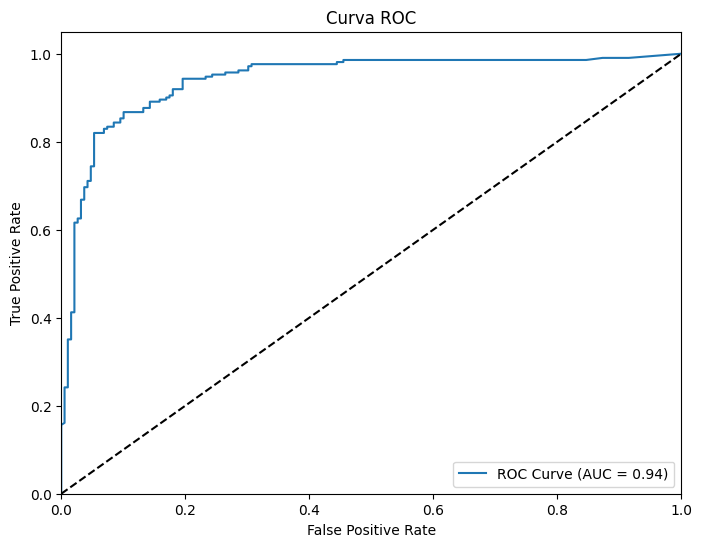

Miglior Threshold: 0.34
F1 Score Ottimizzato: 0.89


In [31]:
# Calcola le probabilità di classe previste dal modello
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilità della classe positiva

# Calcola la curva ROC e l'area sotto la curva (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Plotta la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Calcola il valore F1-score ottimizzato
f1_scores = []
for threshold in thresholds:
    y_pred_threshold = [1 if prob >= threshold else 0 for prob in y_pred_prob]
    f1 = f1_score(y_test, y_pred_threshold)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f'Miglior Threshold: {best_threshold:.2f}')
print(f'F1 Score Ottimizzato: {best_f1_score:.2f}')

# Validation

In [32]:
# Previsioni sul set di test
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilità della classe positiva
y_pred_threshold = [1 if prob >= best_threshold else 0 for prob in y_pred_prob]


# Calcolo delle metriche
accuracy = accuracy_score(y_test, y_pred_threshold)
precision = precision_score(y_test, y_pred_threshold)
recall = recall_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
roc_auc_score_value = roc_auc_score(y_test, y_pred_threshold)

# Stampa le metriche
print(f'Accuratezza: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Roc auc score: {roc_auc_score_value}')

Accuratezza: 0.8775
Precision: 0.8432203389830508
Recall: 0.943127962085308
F1 Score: 0.890380313199105
Roc auc score: 0.873680383159056


# Cross Valdation

In [9]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')
print(f'Cross-Validation Precision Scores: {cv_scores}')
print(f'Average Precision: {np.mean(cv_scores)}')

Cross-Validation Precision Scores: [0.87730061 0.9205298  0.86585366 0.89102564 0.88050314]
Average Precision: 0.8870425718075501


# Confusion Matrix

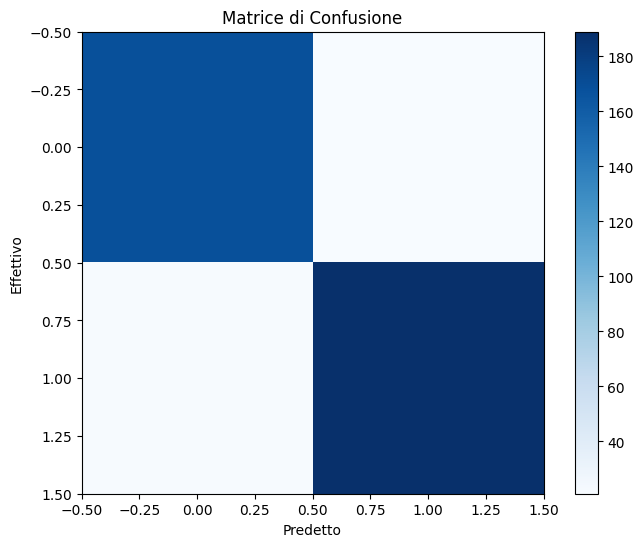

In [10]:
# Calcola la matrice di confusione
confusion = confusion_matrix(y_test, y_pred_threshold)

# Plot della matrice di confusione
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap='Blues')
plt.title('Matrice di Confusione')
plt.colorbar()
plt.xlabel('Predetto')
plt.ylabel('Effettivo')
plt.show()


# Features Importance

In [19]:
# Calcola l'importanza delle feature
feature_importance = model.feature_importances_

# Associa le importanze alle corrispondenti feature
feature_names = X_encoded.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
1,somma_entrate_entrate_regolari__number_peaks__n_3,0.097277
6,somma_entrate_entrate_regolari__number_peaks__n_1,0.087581
7,somma_entrate_entrate_regolari__number_peaks__...,0.065803
2,somma_entrate_scambio_soldi_tra_privati__numbe...,0.055167
28,somma_entrate_entrate_regolari__last_location_...,0.051139
...,...,...
70,somma_uscite_scambio_soldi_tra_privati__last_l...,0.000515
77,somma_uscite_altre_spese__number_peaks__n_50,0.000134
75,somma_entrate_investimenti_patrimonio__c3__lag_1,0.000012
72,somma_uscite_scambio_soldi_tra_privati__median,0.000005
